# Sinkhorn Algorithm
___

In this notebook, we will implement the most celebrated algorithm for entropy-regularized OT.
It is called _Sinkhorn algorithm_, which originates from the matrix scaling algorithm for finding double stochastic matrix from the given entrywise positive one.

Recall entropy-regularized OT problem:
$$
\begin{align*}
\min_{P \in \mathbb{R}^{n \times m}} \quad & \sum_{i=1}^{n} \sum_{j=1}^{m} C_{ij} P_{ij}  + \varepsilon \sum_{i=1}^{n} \sum_{j=1}^{m} P_{ij} \log P_{ij}\\
\text{s.t. } \quad & P \textbf{1}_m = \rho_1 \\
& P^\top \textbf{1}_n = \rho_2 \\
& P \geq 0
\end{align*}
$$
for given cost matrix $C \in \mathbb{R}^{n \times n}$, marginals $\rho_1 \in \mathbb{R}^n_{++}$, $\rho_2 \in \mathbb{R}^m_{++}$, and the regularization value $\varepsilon > 0$.

Adding entropy regularization adds a few nice properties we couldn't dream about without it.
Firstly, the problem becomes strictly convex, which guarantees uniqueness of the solution.
Moreover, the optimal plan is characterized and is given by (prop. 4.3 in [1])
$$
    P_{ij} = u_i K_{ij} v_j \quad \forall i = 1, \dots, n, j = 1, \dots, m,
$$
where $K_{ij} = e^{-\frac{C_{ij}}{\varepsilon}}$ a *kernel matrix*, $u \in \mathbb{R}^n_{++}, v \in \mathbb{R}^m_{++}$ are (unknown) *scaling vectors*.

The other benefit is unconstrained dual problem, where instead we get soft penalization of the usual constraint:
$$
\begin{align*}
\max_{\substack{w_1 \in \mathbb{R}^n \\ w_2 \in \mathbb{R}^m}} \rho_1 \cdot w_1 + \rho_2 \cdot w_2 - \varepsilon \sum_{i = 1}^n \sum_{j = 1}^m \exp \left( \frac{w_{1, i} + w_{2, j} - C}{\varepsilon} \right).
\end{align*}
$$
Unconstrained maximization opens a venue for a great variety of algorithms.
However, the Sinkhorn algorithm worth our special attention due to its unprecedented simplicity and efficiency.

Starting from $u^{(0)} \in \mathbb{R}^n_{++}, v^{(0)} \in \mathbb{R}^m_{++}$, Sinkhorn algorithm produces pairs $(u^{(n)}, v^{(n)})$ such that
$$
    u^{(n+1)} = \frac{\rho_1}{K v^{(n)} }
    \qquad
    v^{(n+1)} = \frac{\rho_2}{K^\top u^{(n+1)}},
$$
which eventually will converge to the scaling vectors $u^*$ and $v^*$ such that $ P^* = \operatorname{diag}(u^*) K \operatorname{diag}(v^*)$ is solution of entropy-regularized OT problem.
Above, division of the vectors should be understood elementwise.

In [1]:
import numpy as np
import ot
from ot.datasets import make_1D_gauss  # Convenient tool to initialize marginals as Gauss distribution
from ot import plot
import matplotlib.pyplot as plt
from scipy.special import logsumexp, softmax  # Will need these later

In [2]:
def ot_entr_primal_cost(C: np.ndarray, P: np.ndarray, eps: float) -> float:
    entr_term = np.empty_like(P)
    entr_term = np.log(P, where=P > 0, out=entr_term)
    entr_term *= P
    return np.vdot(C, P) + eps * entr_term.sum()

## Defining OT Problem

In [3]:
n = 100
m = 70

# Initialize marginals as normal distribution restricted to [0, n], normalized to 1
rho1 = make_1D_gauss(n, m=20, s=5)  # m=mean, s=std
rho2 = make_1D_gauss(n, m=60, s=10)

# Initialize cost matrix
x = np.arange(n, dtype=np.float64)
C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))  # OT tool for building distance matrix
C = C / C.max()  # Normalize for Sinkhorn algorithm stability

### Solution of OT for the Reference
___
Below we solve unregularized OT problem for future comparison with solution of regularized OT.

Optimal value:  0.16580581101906636


(<Axes: >, <Axes: >, <Axes: >)

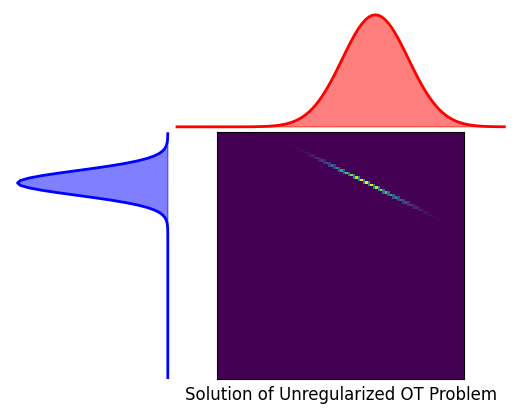

In [4]:
P_star = ot.emd(rho1, rho2, C)
unreg_val = np.vdot(C, P_star)
print('Optimal value: ', unreg_val)
plot.plot1D_mat(rho1, rho2, P_star, 'Solution of Unregularized OT Problem', coupling_cmap='viridis')

## Sinkhorn Algorithm Implementation
___
Let's now implement the Sinkhorn algorithm by directly implementing the formulas.

In [5]:
eps = .001  # Regularization parameter
n_iters = 1000  # Number of Sinkhorn iterations

K = np.exp(-C / eps)  # Compute the kernel matrix

In [6]:
# Initial choice for the scaling variables
u = np.ones(n)
v = np.ones(n)

# Run the Sinkhorn algorithm
for i in range(n_iters):
    u = rho1 / (K @ v)
    v = rho2 / (K.T @ u)

L2 error in the first marginal:  4.2461095067005553e-17
L2 error in the second marginal:  3.6092688791738964e-17
Optimal value:  0.16626805278802934 ; abs. difference with unregularized OT value:  0.00510151641885645


(<Axes: >, <Axes: >, <Axes: >)

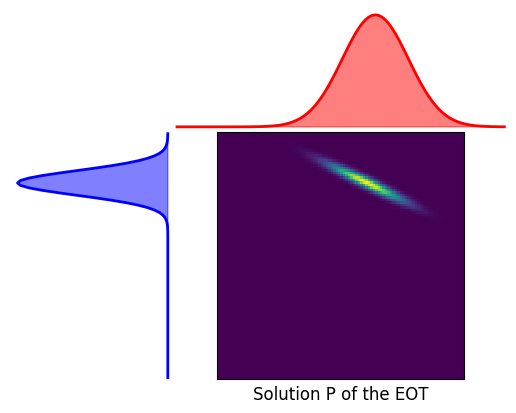

In [7]:
P_sink1 = np.diag(u) @ K @ np.diag(v)  # Compute the transport plan from obtained scaling variables
P_sink1 = P_sink1 / P_sink1.sum()
sink1_val = ot_entr_primal_cost(C, P_sink1, eps)

print('L2 error in the first marginal: ', np.linalg.norm(P_sink1.sum(1) - rho1))
print('L2 error in the second marginal: ', np.linalg.norm(P_sink1.sum(0) - rho2))
print('Optimal value: ', np.vdot(C, P_sink1), '; abs. difference with unregularized OT value: ', abs(unreg_val - sink1_val))
ot.plot.plot1D_mat(rho1, rho2, P_sink1, 'Solution P of the EOT', coupling_cmap='viridis')

### Sinkhorn algorithm using POT
___
Fortunately, in POT (Python Optimal Transport) there is an implementation of the algorithm,
incorporating some computational tricks to make the procedure faster and more stable.

Here is how usual call looks like:

L2 error in the first marginal:  6.404151239944628e-17
L2 error in the second marginal:  6.839572158384321e-10
Optimal value:  0.16626805231855674 ; abs. difference with unregularized OT value:  0.00046224129949037907


(<Axes: >, <Axes: >, <Axes: >)

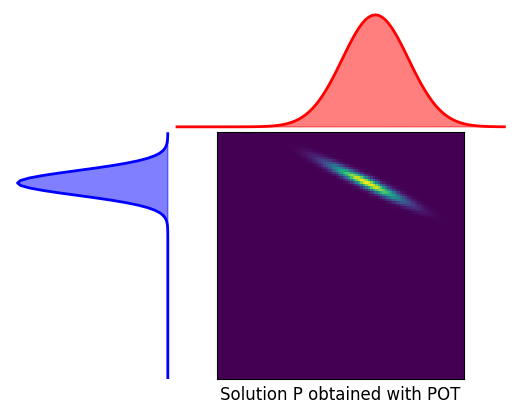

In [8]:
P_pot = ot.bregman.sinkhorn(rho1, rho2, C, eps, numItermax=n_iters)
sink2_val = np.vdot(C, P_pot)

print('L2 error in the first marginal: ', np.linalg.norm(P_pot.sum(1) - rho1))
print('L2 error in the second marginal: ', np.linalg.norm(P_pot.sum(0) - rho2))
print('Optimal value: ', np.vdot(C, P_pot), '; abs. difference with unregularized OT value: ', abs(unreg_val - sink2_val))
ot.plot.plot1D_mat(rho1, rho2, P_pot, 'Solution P obtained with POT', coupling_cmap='viridis')

## Impact of $\varepsilon$ on the Solution
___
If we play around with the regularization parameter, we may notice how EOT solution with small regularization value starts to look like transport plan, i.e. it becomes more sparse with value concentrated on the line.
And vice versa, the bigger $\varepsilon$, the closer solution approaches $\rho_1 \rho_2^\top$.

This behavior is fundamental property of EOT (see prop.4.1. in [1]), allowing us to approximate solution of the original problem.

Let's visualize how the solution changes depending on the value of $\varepsilon$:

/var/folders/xc/w2169vxs011c9kt0dpwjl5mc0000gn/T/ipykernel_75845/969642486.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


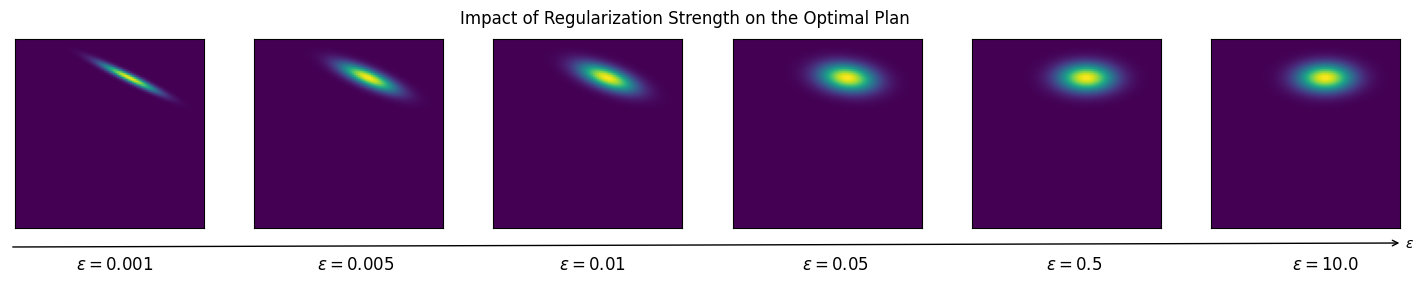

In [9]:
eps_list = [0.001, 0.005, .01, .05, .5, 10.]  # List of regularizations to compute EOT (you can put your own)
n_plots = len(eps_list)

# Create a figure and a list of axes for the subplots
fig, axs = plt.subplots(1, n_plots, figsize=(3*n_plots, 3), sharey=True)

# Generate example data and plot each subplot
vals = []  # Store optimal values
for ax, eps in zip(axs, eps_list):
    p = ot.bregman.sinkhorn(rho1, rho2, C, eps, numItermax=1000)
    vals.append(ot_entr_primal_cost(C, p, eps))
    ax.imshow(p)

    # Hide x-axis labels and ticks for individual plots
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


# Create an axis below all subplots for a common axis
fig.subplots_adjust(bottom=0.25)
common_ax = fig.add_subplot(111, label='common', frame_on=False)
common_ax.tick_params(labelcolor='black', top=False, bottom=False, left=False, right=False)

# Set ticks at positions corresponding to the center of each subplot
x_lims = (0, (3.5)*n_plots)
common_ax.set_xlim(*x_lims)
common_ax.set_xticks([])
common_ax.set_yticks([])
margin_width = (x_lims[1] - 3*n_plots) / (n_plots - 1)
tick_positions = []
curr_tick_p = 1.
for i in range(n_plots):
    common_ax.text(curr_tick_p, -0.19, r'$\epsilon=$'+f'${round(eps_list[i], 3)}$', fontsize=12, ha='left', va='center')
    curr_tick_p += 3.6
    curr_tick_p *= 1.005

# Draw an arrowed axis
common_ax.annotate(r'$\varepsilon$', xy=(0, -0.1), xytext=(1, -0.1), xycoords='axes fraction', textcoords='axes fraction',
                   arrowprops=dict(arrowstyle="<-", color='black'))

fig.suptitle('Impact of Regularization Strength on the Optimal Plan')
fig.show()

### How Regularized Optimal Value Approaches Unregularized One
___
Below, $p^*$ denotes value of unregularized OT, whereas $p_\varepsilon$ denotes value of entropy-regularized OT with regularization $\varepsilon$.
It is visible now that weakening the regularization leads to unregularized optimal value.

Text(0.5, 1.0, 'Convergence Plot for Diminishing Regularization')

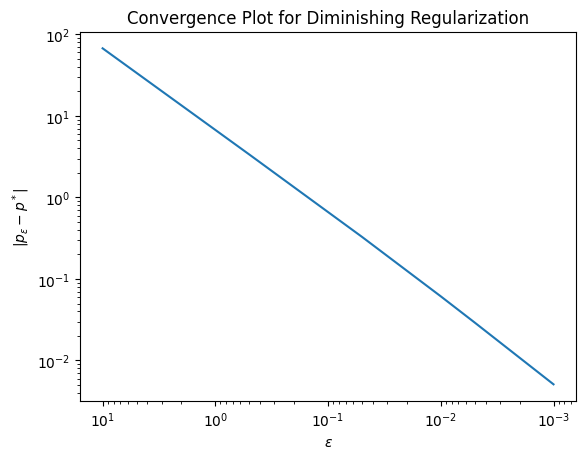

In [10]:
fig, ax = plt.subplots()

vals = np.asarray(vals)
X = eps_list
Y = np.abs(vals - unreg_val)

ax.loglog(X, Y)
ax.invert_xaxis()
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel(r'$|p_\varepsilon - p^* |$')
ax.set_title('Convergence Plot for Diminishing Regularization')

## Under- and Overflow
___
Sinkhorn algorithm provides powerful tool as long as regularization strength $\varepsilon > 0$ is large enough.
The smaller it is, the more disperse become entries of $K_{ij} = e^{-\frac{C_{ij}}{\varepsilon}}$ — the small entries get smaller, and large ones approach near-infinity values.
All this leads to numerical instability (for instance, division by zero).

One of possible remedies is to work with logarithms of the scaling vectors — this way we never use division and work with log-sum-exp — the operation that appears in various applications and has stable implementation (compared to performing all these three operations one by one separately).

**Implementation.** Introduce now $\alpha^{(n)} = \log u^{(n)}$ and $\beta^{(n)} = \log v^{(n)}$.
Then the Sinkhorn iterations are:
$$
\begin{align*}
    \alpha^{(n+1)}
    &= \log \rho_1 - \log(K v^{(n)})
    = \log \rho_1 - \left[\log\left(\sum_{j = 1}^m \exp \left( \beta^{(n)}_j - \frac{K_{ij}}{\varepsilon} \right) \right)\right]_{i = 1}^n,
\end{align*}
$$
and, similarly,
$$
\begin{align*}
    \beta^{(n+1)}
    &= \log \rho_2 - \log(K^\top u^{(n + 1)})
    = \log \rho_2 - \left[\log\left(\sum_{i = 1}^n \exp \left( \alpha^{(n + 1)}_i - \frac{K_{ij}}{\varepsilon} \right) \right)\right]_{j = 1}^m,
\end{align*}
$$
where log-sum-exp function pops up.

In this way, we can use smaller values of $\varepsilon$, compared to naïve implementation of Sinkhorn algorithm.
However, smaller regularization demands higher number of iterations to converge.

In [11]:
eps = 1e-6
n_iters = 80000

log_a = np.log(rho1)
log_b = np.log(rho2)

n, m = C.shape
alpha = np.zeros(n)
beta  = np.zeros(m)

for _ in range(n_iters):
    log_Kv = logsumexp(beta[None, :] - C / eps, axis=1)
    alpha = log_a - log_Kv

    log_KTu = logsumexp(alpha[:, None] - C / eps, axis=0)
    beta = log_b - log_KTu

L2 error in the first marginal:  1.9444546844389117e-12
L2 error in the second marginal:  1.8424636846551166e-12
Optimal value:  0.16580174396352562 ; abs. difference with unregularized OT value:  4.067055540735165e-06


(<Axes: >, <Axes: >, <Axes: >)

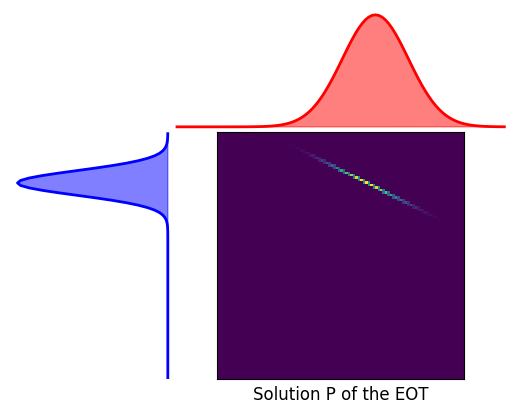

In [12]:
P_logsink = softmax(alpha[:, None] + beta[None, :] - C / eps)
logsink_val = ot_entr_primal_cost(C, P_logsink, eps)

print('L2 error in the first marginal: ', np.linalg.norm(P_logsink.sum(1) - rho1))
print('L2 error in the second marginal: ', np.linalg.norm(P_logsink.sum(0) - rho2))
print('Optimal value: ', logsink_val, '; abs. difference with unregularized OT value: ', abs(unreg_val - logsink_val))
ot.plot.plot1D_mat(rho1, rho2, P_logsink, 'Solution P of the EOT', coupling_cmap='viridis')

## References
___
[1] Gabriel Peyré and Marco Cuturi, Computational Optimal Transport, 2018